In [1]:
import gymnasium as gym
from gymnasium import spaces

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:


# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)


In [4]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-02-24 15:22:00+00:00,399.679993,400.359985,399.470001,399.695007,176310,400.936005,401.139486,34.991452,-1.451712,-1.625985,401.534422,403.138729,399.930116,401.707731,401.691804,403.159103,405.530900
2025-02-24 15:24:00+00:00,400.415009,400.670013,399.410004,399.744995,148168,400.906003,400.997759,37.455541,-1.419254,-1.584638,401.468997,403.154931,399.783064,401.586177,401.621007,403.044507,405.345507
2025-02-24 15:26:00+00:00,399.695007,400.480011,399.369995,400.393005,137562,400.869003,400.938169,39.500901,-1.352918,-1.538294,401.416498,403.134607,399.698389,401.533755,401.132486,402.253765,404.066243
2025-02-24 15:28:00+00:00,399.790009,399.970001,399.579987,399.684998,117335,400.885504,400.854867,38.572169,-1.300685,-1.490773,401.305998,402.962406,399.649591,401.489049,400.660486,401.489765,402.830243
2025-02-24 15:30:00+00:00,399.910004,400.070007,399.660004,399.815002,123465,400.801505,400.693983,37.196247,-1.285623,-1.449743,401.139499,402.611122,399.667875,401.382891,400.507087,401.241467,402.428547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-10 19:50:00+00:00,381.320007,381.589996,378.260010,378.260010,357579,380.348993,380.183390,25.030014,-0.196338,0.220152,381.189577,383.830536,378.548618,381.189289,378.831403,379.729303,381.180701
2025-04-10 19:52:00+00:00,381.480011,381.989990,381.049988,381.290009,248607,380.380002,380.439137,41.666834,-0.081046,0.159913,381.239996,383.870566,378.609427,381.171812,378.831403,379.729303,381.180701
2025-04-10 19:54:00+00:00,380.910004,383.000000,379.260010,381.589996,530972,380.387000,380.721110,48.786569,0.042113,0.136353,381.282745,383.933840,378.631651,381.259233,378.831403,379.729303,381.180701


In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

## Step is to trade one stock at a time

In [12]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, initial_stock=10, context_width=10, offset=3):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.initial_stock = initial_stock  # NEW

        self.context_width = context_width
        self.offset = offset
        self.num_features = df.shape[1]

        self.action_space = spaces.Discrete(3)

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width, self.num_features + 2),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = self.initial_stock  # NEW

        if seed is not None:
            np.random.seed(seed)

        obs = self._get_obs()
        info = {}
        return obs, info

    def render(self, mode="human"):
        if self.current_step >= len(self.df):
            print("End of data reached. No further rendering possible.")
            return

        price = self.df.iloc[self.current_step]["Close"]
        net_worth = self.cash + self.stock_held * price
        profit_loss = net_worth - (self.initial_cash + self.initial_stock * price)
        status = "PROFIT" if profit_loss > 0 else "LOSS" if profit_loss < 0 else "BREAKEVEN"

        print(f"Step: {self.current_step}, Cash: {self.cash:.2f}, Stock: {self.stock_held}, "
              f"Net Worth: {net_worth:.2f}, P/L: {profit_loss:.2f} ({status})")



    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        obs = np.concatenate((window, cash_stock), axis=1)
        return obs  # 2D now: [context_width x (features + 2)]

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
    
        current_price = self.df.iloc[self.current_step]["Close"]
        prev_total_asset = self.cash + self.stock_held * current_price
    
        # --- Execute Action ---
        if action == 1 and self.cash >= current_price:  # Buy
            self.cash -= current_price
            self.stock_held += 1
        elif action == 2 and self.stock_held > 0:       # Sell
            self.cash += current_price
            self.stock_held -= 1
        # else: HOLD → no action taken
    
        self.current_step += 1
    
        if self.current_step + self.offset >= len(self.df):
            terminated = True
            self.current_step = len(self.df) - 1
        # Reward Logic
        next_price = self.df.iloc[self.current_step]["Close"] if self.current_step < len(self.df) else current_price
        current_total_asset = self.cash + self.stock_held * next_price
    
        reward = current_total_asset - prev_total_asset
    
        # Optionally add HOLD-specific logic
        if action == 0:  # HOLD
            price_change = next_price - current_price
            if self.stock_held > 0:
                reward += price_change  # Reward holding if price is going up
            else:
                reward -= abs(price_change) * 0.1  # Small penalty for holding when not invested
    
        obs = self._get_obs()
        return obs, reward, terminated, truncated, info


In [14]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-02-24 15:22:00+00:00,399.679993,400.359985,399.470001,399.695007,176310,400.936005,401.139486,34.991452,-1.451712,-1.625985,401.534422,403.138729,399.930116,401.707731,401.691804,403.159103,405.530900
2025-02-24 15:24:00+00:00,400.415009,400.670013,399.410004,399.744995,148168,400.906003,400.997759,37.455541,-1.419254,-1.584638,401.468997,403.154931,399.783064,401.586177,401.621007,403.044507,405.345507
2025-02-24 15:26:00+00:00,399.695007,400.480011,399.369995,400.393005,137562,400.869003,400.938169,39.500901,-1.352918,-1.538294,401.416498,403.134607,399.698389,401.533755,401.132486,402.253765,404.066243
2025-02-24 15:28:00+00:00,399.790009,399.970001,399.579987,399.684998,117335,400.885504,400.854867,38.572169,-1.300685,-1.490773,401.305998,402.962406,399.649591,401.489049,400.660486,401.489765,402.830243
2025-02-24 15:30:00+00:00,399.910004,400.070007,399.660004,399.815002,123465,400.801505,400.693983,37.196247,-1.285623,-1.449743,401.139499,402.611122,399.667875,401.382891,400.507087,401.241467,402.428547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-10 19:50:00+00:00,381.320007,381.589996,378.260010,378.260010,357579,380.348993,380.183390,25.030014,-0.196338,0.220152,381.189577,383.830536,378.548618,381.189289,378.831403,379.729303,381.180701
2025-04-10 19:52:00+00:00,381.480011,381.989990,381.049988,381.290009,248607,380.380002,380.439137,41.666834,-0.081046,0.159913,381.239996,383.870566,378.609427,381.171812,378.831403,379.729303,381.180701
2025-04-10 19:54:00+00:00,380.910004,383.000000,379.260010,381.589996,530972,380.387000,380.721110,48.786569,0.042113,0.136353,381.282745,383.933840,378.631651,381.259233,378.831403,379.729303,381.180701


## FALSE : offset = 5 → the model only trains/predicts every 5 steps## TRUE : offset = 5 → each action’s reward is based on what happens 5 steps in the future



In [17]:
# ---------------------------
# Training
# ---------------------------
context_width = 10
offset = 1

split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

train_env = TradingEnv(train_df, context_width=context_width, offset=offset)
train_env = DummyVecEnv([lambda: train_env])

steps_per_episode = df.shape[0] - context_width
total_timesteps = 100 * steps_per_episode

model = DQN("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=total_timesteps)




Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 496      |
|    time_elapsed     | 37       |
|    total_timesteps  | 18416    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 41.9     |
|    n_updates        | 4578     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 458      |
|    time_elapsed     | 80       |
|    total_timesteps  | 36832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 126      |
|    n_updates        | 9182     |
----------------------------------
----------------------------------
| rollout/            |          |
| 

Step: 11, Cash: 608.21, Stock: 11, Net Worth: 4918.24, P/L: 0.04 (PROFIT)
Step: 12, Cash: 1000.04, Stock: 10, Net Worth: 4917.73, P/L: 0.04 (PROFIT)
Step: 13, Cash: 1391.80, Stock: 9, Net Worth: 4920.44, P/L: -0.27 (LOSS)
Step: 14, Cash: 999.73, Stock: 10, Net Worth: 4920.44, P/L: -0.27 (LOSS)
Step: 15, Cash: 607.66, Stock: 11, Net Worth: 4920.67, P/L: -0.24 (LOSS)
Step: 16, Cash: 999.76, Stock: 10, Net Worth: 4919.66, P/L: -0.24 (LOSS)
Step: 17, Cash: 607.77, Stock: 11, Net Worth: 4919.77, P/L: -0.23 (LOSS)
Step: 18, Cash: 215.77, Stock: 12, Net Worth: 4912.63, P/L: -1.42 (LOSS)
Step: 19, Cash: 215.77, Stock: 12, Net Worth: 4912.57, P/L: -1.43 (LOSS)
Step: 20, Cash: 607.17, Stock: 11, Net Worth: 4911.85, P/L: -1.50 (LOSS)
Step: 21, Cash: 998.50, Stock: 10, Net Worth: 4913.00, P/L: -1.50 (LOSS)
Step: 22, Cash: 607.05, Stock: 11, Net Worth: 4911.68, P/L: -1.62 (LOSS)
Step: 23, Cash: 215.72, Stock: 12, Net Worth: 4912.16, P/L: -1.54 (LOSS)
Step: 24, Cash: 607.09, Stock: 11, Net Worth: 49

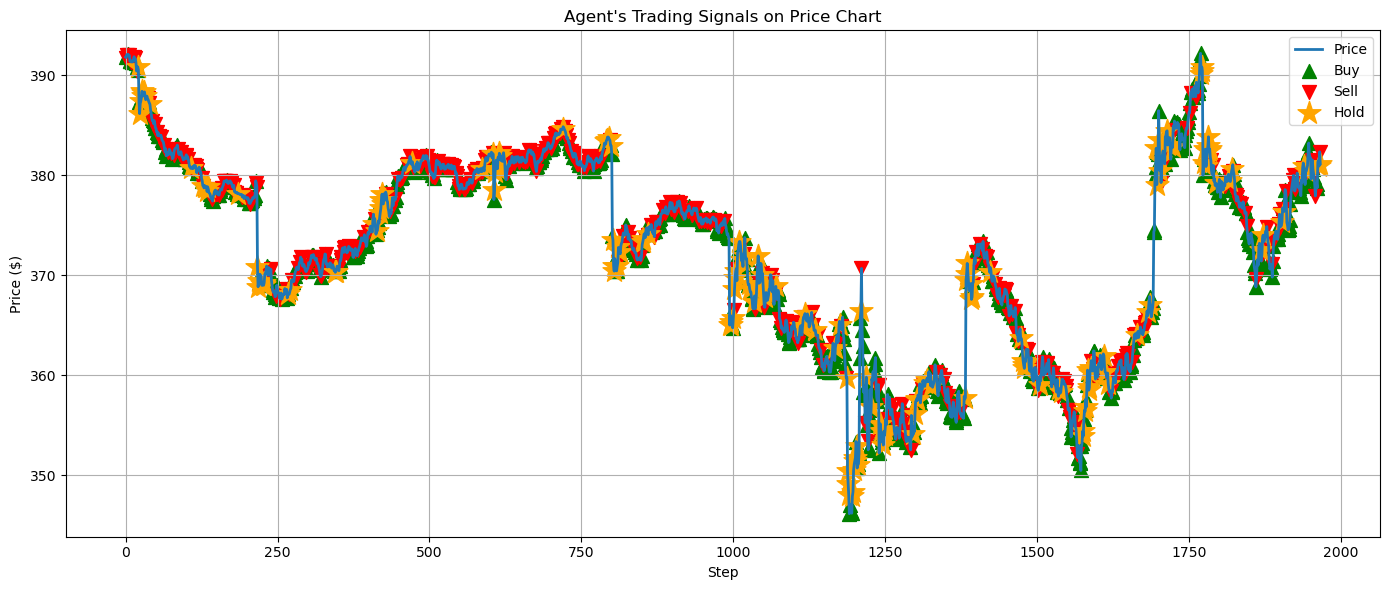

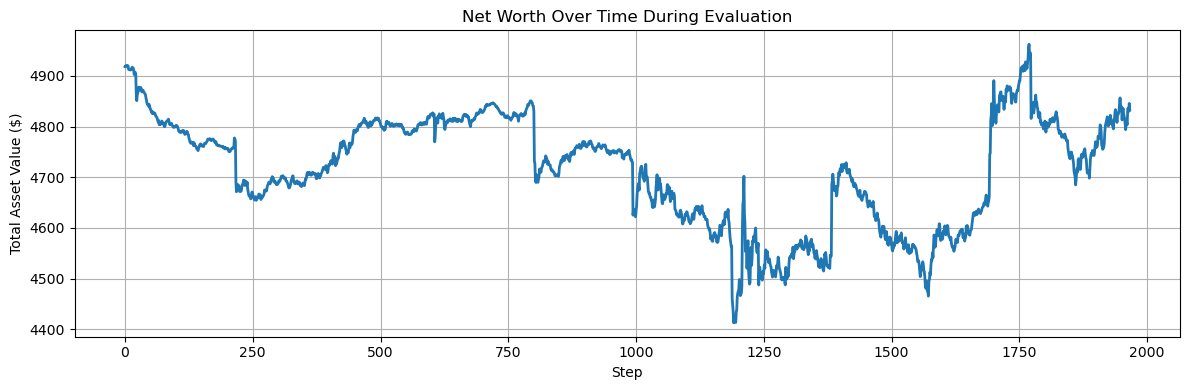

In [18]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df, context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Logging actions, prices, net worth...
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

    # SEE RENDER OUTPUT
    test_env.render()  

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 631.02, Stock: 11, Net Worth: 4684.30, P/L: -0.50 (LOSS)
Step: 12, Cash: 262.54, Stock: 12, Net Worth: 4681.96, P/L: -0.89 (LOSS)
Step: 13, Cash: 262.54, Stock: 12, Net Worth: 4681.06, P/L: -1.04 (LOSS)
Step: 14, Cash: 262.54, Stock: 12, Net Worth: 4675.60, P/L: -1.95 (LOSS)
Step: 15, Cash: 630.29, Stock: 11, Net Worth: 4674.40, P/L: -2.06 (LOSS)
Step: 16, Cash: 262.65, Stock: 12, Net Worth: 4678.65, P/L: -1.35 (LOSS)
Step: 17, Cash: 262.65, Stock: 12, Net Worth: 4681.11, P/L: -0.94 (LOSS)
Step: 18, Cash: 262.65, Stock: 12, Net Worth: 4673.85, P/L: -2.15 (LOSS)
Step: 19, Cash: 262.65, Stock: 12, Net Worth: 4676.13, P/L: -1.77 (LOSS)
Step: 20, Cash: 630.44, Stock: 11, Net Worth: 4679.10, P/L: -1.50 (LOSS)
Step: 21, Cash: 262.38, Stock: 12, Net Worth: 4678.80, P/L: -1.55 (LOSS)
Step: 22, Cash: 262.38, Stock: 12, Net Worth: 4679.36, P/L: -1.46 (LOSS)
Step: 23, Cash: 262.38, Stock: 12, Net Worth: 4686.27, P/L: -0.31 (LOSS)
Step: 24, Cash: 262.38, Stock: 12, Net Worth: 4682.

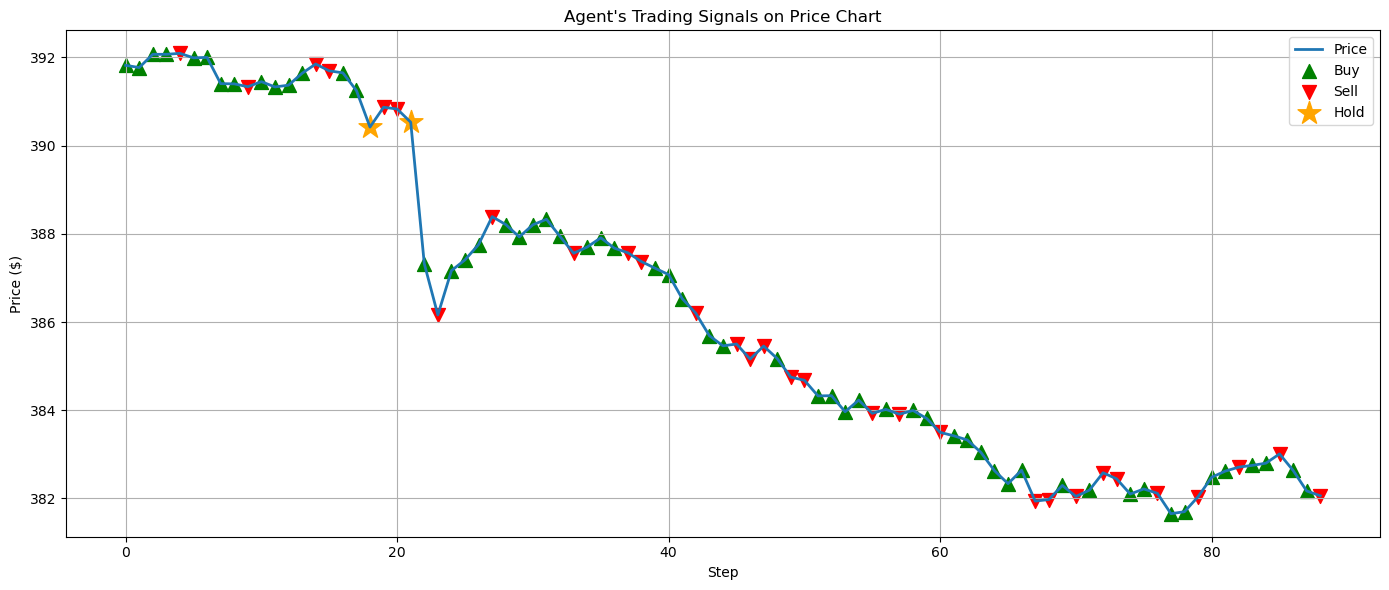

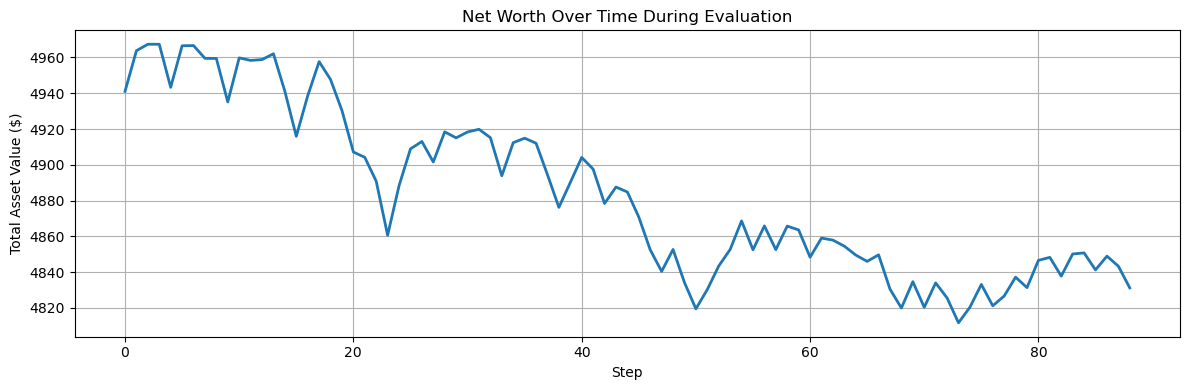

In [19]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[250:350], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()  
    

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 1381.10, Stock: 9, Net Worth: 4808.39, P/L: 0.29 (PROFIT)
Step: 12, Cash: 1000.29, Stock: 10, Net Worth: 4803.79, P/L: 0.29 (PROFIT)
Step: 13, Cash: 619.94, Stock: 11, Net Worth: 4803.52, P/L: 0.27 (PROFIT)
Step: 14, Cash: 1000.27, Stock: 10, Net Worth: 4803.17, P/L: 0.27 (PROFIT)
Step: 15, Cash: 619.97, Stock: 11, Net Worth: 4799.87, P/L: -0.04 (LOSS)
Step: 16, Cash: 999.96, Stock: 10, Net Worth: 4799.46, P/L: -0.04 (LOSS)
Step: 17, Cash: 620.01, Stock: 11, Net Worth: 4801.44, P/L: 0.14 (PROFIT)
Step: 18, Cash: 239.88, Stock: 12, Net Worth: 4795.92, P/L: -0.78 (LOSS)
Step: 19, Cash: 619.55, Stock: 11, Net Worth: 4797.68, P/L: -0.62 (LOSS)
Step: 20, Cash: 999.38, Stock: 10, Net Worth: 4797.58, P/L: -0.62 (LOSS)
Step: 21, Cash: 1379.20, Stock: 9, Net Worth: 4803.07, P/L: -1.23 (LOSS)
Step: 22, Cash: 998.77, Stock: 10, Net Worth: 4810.67, P/L: -1.23 (LOSS)
Step: 23, Cash: 617.58, Stock: 11, Net Worth: 4814.08, P/L: -0.92 (LOSS)
Step: 24, Cash: 999.08, Stock: 10, Net Worth

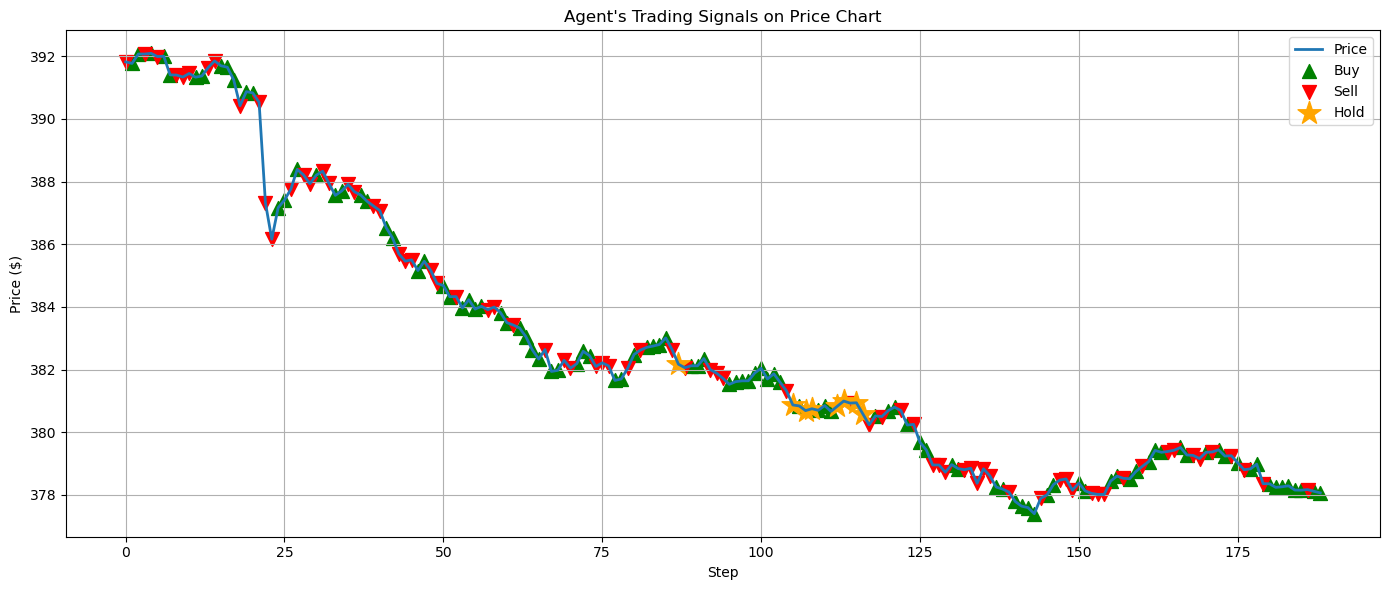

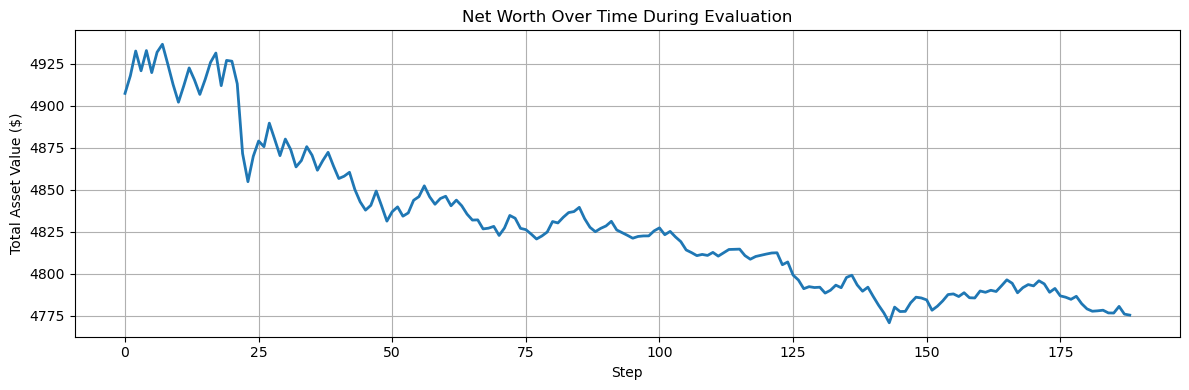

In [20]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[500:700], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()  
    

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 643.94, Stock: 11, Net Worth: 4574.74, P/L: 1.29 (PROFIT)
Step: 12, Cash: 1001.29, Stock: 10, Net Worth: 4575.79, P/L: 1.29 (PROFIT)
Step: 13, Cash: 1001.29, Stock: 10, Net Worth: 4577.69, P/L: 1.29 (PROFIT)
Step: 14, Cash: 1001.29, Stock: 10, Net Worth: 4575.88, P/L: 1.29 (PROFIT)
Step: 15, Cash: 643.83, Stock: 11, Net Worth: 4581.88, P/L: 1.83 (PROFIT)
Step: 16, Cash: 285.82, Stock: 12, Net Worth: 4579.66, P/L: 1.46 (PROFIT)
Step: 17, Cash: 285.82, Stock: 12, Net Worth: 4576.72, P/L: 0.97 (PROFIT)
Step: 18, Cash: 285.82, Stock: 12, Net Worth: 4595.38, P/L: 4.08 (PROFIT)
Step: 19, Cash: 285.82, Stock: 12, Net Worth: 4572.43, P/L: 0.26 (PROFIT)
Step: 20, Cash: 285.82, Stock: 12, Net Worth: 4580.26, P/L: 1.56 (PROFIT)
Step: 21, Cash: 643.69, Stock: 11, Net Worth: 4588.45, P/L: 2.30 (PROFIT)
Step: 22, Cash: 285.08, Stock: 12, Net Worth: 4587.56, P/L: 2.16 (PROFIT)
Step: 23, Cash: 285.08, Stock: 12, Net Worth: 4598.48, P/L: 3.98 (PROFIT)
Step: 24, Cash: 644.53, Stock: 11, 

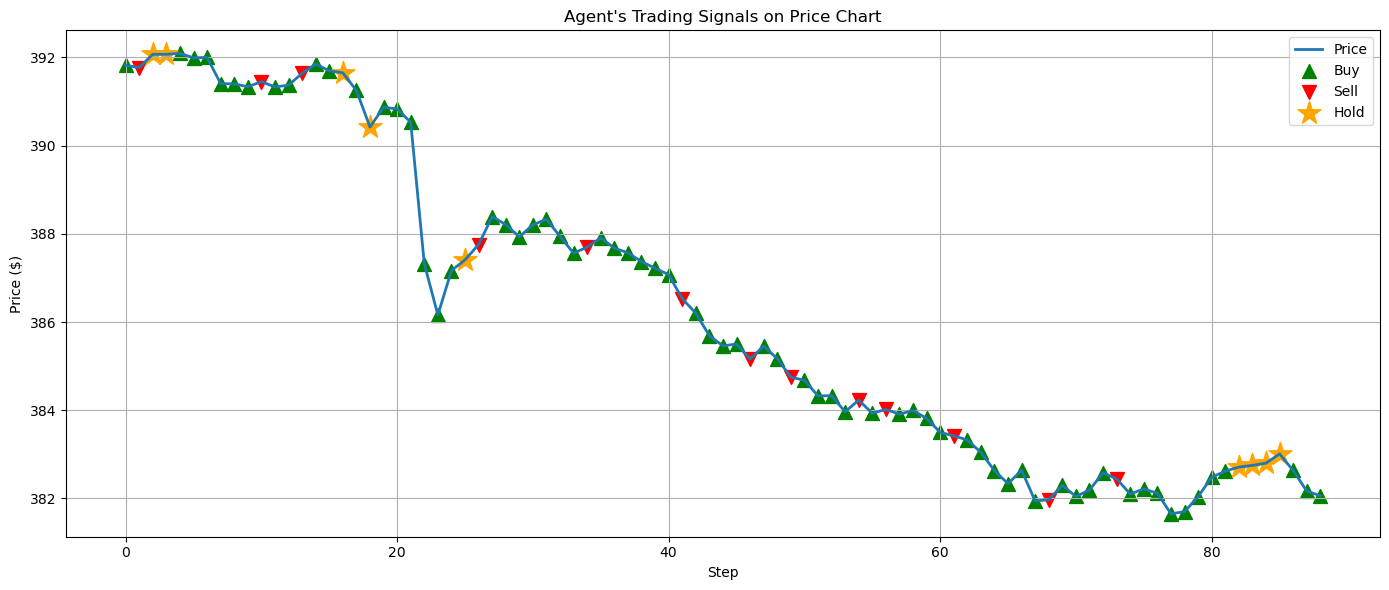

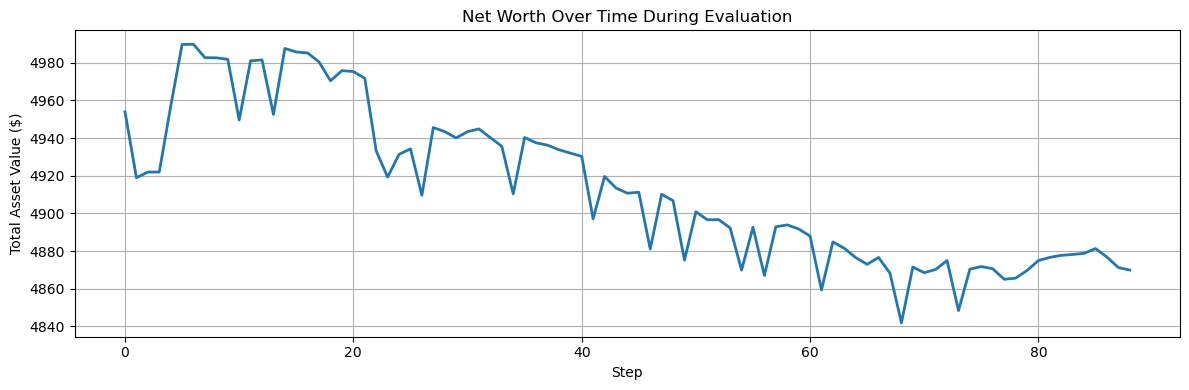

In [31]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[1300:1400], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Logging actions, prices, net worth...
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

    # SEE RENDER OUTPUT
    test_env.render()  

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=300, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
df.iloc[1700]

Close            395.470001
High             395.750000
Low              395.450012
Open             395.540009
Volume         50725.000000
SMA_10           396.231396
EMA_10           395.933318
RSI_14            66.459379
MACD              -0.025576
Signal_Line       -0.080543
BB_Mid           395.678448
BB_Upper         397.125618
BB_Lower         394.231279
VWAP             395.843891
Fib_23.6         394.907308
Fib_38.2         395.326314
Fib_61.8         396.003611
Name: 2025-03-06 20:08:00+00:00, dtype: float64

In [39]:
df.iloc[1900]

Close            392.980011
High             393.070007
Low              392.329987
Open             392.369995
Volume         35203.000000
SMA_10           393.142059
EMA_10           393.142457
RSI_14            39.503284
MACD               0.023832
Signal_Line        0.120315
BB_Mid           393.317758
BB_Upper         394.227650
BB_Lower         392.407867
VWAP             393.366567
Fib_23.6         392.447041
Fib_38.2         392.791586
Fib_61.8         393.348521
Name: 2025-03-07 20:18:00+00:00, dtype: float64